In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../galess")
import lens_plot
import HOD

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/giofer/anaconda3/envs/HOD/lib/python3.11/site-packages/halomod/halo_exclusion.py:18: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  warnings.warn(


In [149]:
_theta_ = 1

z = 1.7
M_sat, M_min, sigma_logM, alpha = 10**14.18, 10**12.46, 0.2, 1.0
z_array = np.array([1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2])
N_z_nrm = np.array([0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0])

from scipy import integrate
from scipy import special
import mpmath
from hmf import MassFunction
from halomod.bias import Tinker10
from astropy.cosmology import FlatLambdaCDM
cosmo  = FlatLambdaCDM(H0=67.74, Om0=0.3089, Tcmb0=2.725)
OmegaM = cosmo.Om(0)
OmegaL = cosmo.Ode(0)
OmegaK = cosmo.Ok(0)
OmegaB = 0.049
OmegaC = OmegaM-OmegaB
H0 = cosmo.H(0).value
h  = H0/100
c_light  = 299792.458

_PS_NORM_ = HOD.norm_power_spectrum()
M_h_array, HMF_array, nu_array, hmf_k, hmf_PS = HOD.init_lookup_table(z, REWRITE_TBLS=False)
NCEN = HOD.N_cen(M_h_array, M_min, sigma_logM)
NSAT = HOD.N_sat(M_h_array, M_sat, alpha, M_min, sigma_logM)
D_ratio   = (HOD.D_growth_factor(z)/HOD.D_growth_factor(0))**2 if z != 0 else 1
bias = Tinker10(nu=nu_array).bias() if 1 else HOD.halo_bias_TINKER(nu_array)
N_G  = HOD.n_g(M_min, sigma_logM, M_sat, alpha, z, M_h_array, HMF_array)
comoving_distance_z = cosmo.comoving_distance(z).value
crit_dens_rescaled = (4/3*np.pi*cosmo.critical_density(z).value*200*2e40)

USE_MY_PS = 0
if (USE_MY_PS): 
    k_array = np.logspace(-3, 3, 2000)
    dlogk = np.log(k_array[1]/k_array[0])
else:
    k_array = hmf_k
    dlogk = np.log(hmf_k[1]/hmf_k[0])
PS_1 = [HOD.PS_1h(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT) for k in k_array]
PS_2 = [HOD.PS_2h(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT, bias, hmf_k, hmf_PS, D_ratio, _PS_NORM_, USE_MY_PS) for k in k_array]
PS_2_corr =  np.array(PS_2) if USE_MY_PS else hmf_PS * np.array(PS_2)
factor = np.array([HOD.factor_k(k, _theta_/206265, comoving_distance_z) for k in k_array])
F_k_hmf = (np.array(PS_1) + PS_2_corr) * factor

def F_k_hmf_func(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT, bias, hmf_k, hmf_PS, D_ratio, _PS_NORM_, USE_MY_PS):
    PS_1 = HOD.PS_1h(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT) 
    PS_2 = HOD.PS_2h(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT, bias, hmf_k, hmf_PS, D_ratio, _PS_NORM_, USE_MY_PS)
    PS_2_corr =  PS_2 if USE_MY_PS else hmf_PS * PS_2
    factor = HOD.factor_k(k, _theta_/206265, comoving_distance_z)
    return np.array((PS_1 + PS_2_corr) * factor)[0]

def func(x, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT, bias, hmf_k, hmf_PS, D_ratio, _PS_NORM_, USE_MY_PS):
    # x = k * _theta_ / 206265 * comoving_distance_z
    k = x / (_theta_ / 206265 * comoving_distance_z)
    PS_1 = HOD.PS_1h(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT) 
    PS_2 = HOD.PS_2h(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT, bias, hmf_k, hmf_PS, D_ratio, _PS_NORM_, USE_MY_PS)
    PS_2_corr =  PS_2 if USE_MY_PS else hmf_PS * PS_2
    factor = HOD.factor_k(k, _theta_/206265, comoving_distance_z)
    return np.array((PS_1 + PS_2_corr) * factor)[0]

from scipy.special import jn_zeros
j_0_zeros = np.append(1e-3, jn_zeros(0,31832))
j_0_zeros = np.append(1e-3, jn_zeros(0,1000))


_args_ = M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT, bias, hmf_k, hmf_PS, D_ratio, _PS_NORM_, USE_MY_PS
INT_hmf = [integrate.quad(func, j_0_zero, j_0_zeros[ij+1], limit=10, epsabs=5e-1, args = (_args_))[0] for ij, j_0_zero in enumerate(j_0_zeros[:-1])]
#INT_hmf = integrate.quad(func, 1e-3, 1e5, limit=1000, epsabs=1e-4, points = j_0_zeros, args = (_args_))[0]

print(INT_hmf[:10], '...', INT_hmf[-4:])
np.sum(INT_hmf), np.abs((np.sum(INT_hmf)-np.sum(INT_hmf[:-1]))/np.sum(INT_hmf))

[9136.265832560759, -238.96635191817336, 49.92998201569732, -21.632053176395747, 12.589139234445586, -8.499329621772121, 6.251735093868226, -4.859599552107807, 3.925258965065181, -3.260054144199099] ... [0.0027551611707609266, -0.0027507056464976466, 0.0027470551360450337, -0.002742947881663942]


(8933.232777957115, 3.070498608503595e-07)

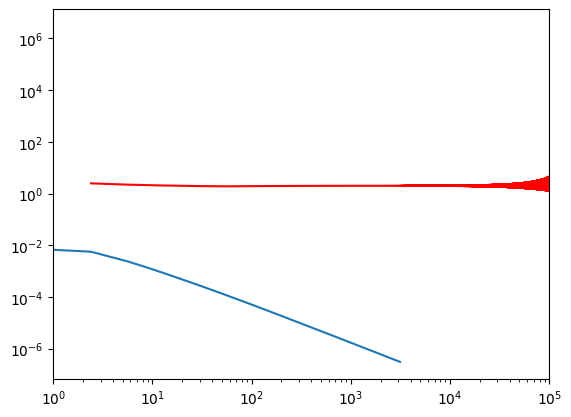

In [145]:
plt.plot(jn_zeros(0,100000)[:-1], np.abs((np.cumsum(long_INT_hmf)[:-1]-np.cumsum(long_INT_hmf)[1:])/np.cumsum(long_INT_hmf)[:-1]), c='r')
plt.plot(j_0_zeros[:-2], np.abs((np.cumsum(INT_hmf)[:-1]-np.cumsum(INT_hmf)[1:])/np.cumsum(INT_hmf)[:-1]))

plt.xscale('log')
plt.yscale('log')
plt.xlim((1,1e5))
plt.show()

In [23]:
_theta_ = 1

z = 1.7
M_sat, M_min, sigma_logM, alpha = 10**14.18, 10**12.46, 0.2, 1.0
z_array = np.array([1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2])
N_z_nrm = np.array([0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0])

if(0):
    z = 5.9
    M_sat, M_min, sigma_logM, alpha = 10**13.73, 10**12.09, 0.2, 1.0
    data = [
    (5.500000e+00, 2.321580e-02),
    (5.600000e+00, 5.284060e-02),
    (5.700000e+00, 1.436010e-01),
    (5.800000e+00, 1.481370e-01),
    (5.900000e+00, 1.036900e-01),
    (6.000000e+00, 1.342000e-01),
    (6.100000e+00, 2.453660e-01),
    (6.200000e+00, 1.546640e-01),
    (6.300000e+00, 1.127430e-02)
    ]
    z_array, N_z_nrm = np.array(data).T

In [24]:
from scipy import integrate
from scipy import special
import mpmath
from hmf import MassFunction
from halomod.bias import Tinker10
from astropy.cosmology import FlatLambdaCDM
cosmo  = FlatLambdaCDM(H0=67.74, Om0=0.3089, Tcmb0=2.725)
OmegaM = cosmo.Om(0)
OmegaL = cosmo.Ode(0)
OmegaK = cosmo.Ok(0)
OmegaB = 0.049
OmegaC = OmegaM-OmegaB
H0 = cosmo.H(0).value
h  = H0/100
c_light  = 299792.458

_PS_NORM_ = HOD.norm_power_spectrum()
M_h_array, HMF_array, nu_array, hmf_k, hmf_PS = HOD.init_lookup_table(z, REWRITE_TBLS=False)
NCEN = HOD.N_cen(M_h_array, M_min, sigma_logM)
NSAT = HOD.N_sat(M_h_array, M_sat, alpha, M_min, sigma_logM)
D_ratio   = (HOD.D_growth_factor(z)/HOD.D_growth_factor(0))**2 if z != 0 else 1
bias = Tinker10(nu=nu_array).bias() if 1 else HOD.halo_bias_TINKER(nu_array)
N_G  = HOD.n_g(M_min, sigma_logM, M_sat, alpha, z, M_h_array, HMF_array)
comoving_distance_z = cosmo.comoving_distance(z).value
crit_dens_rescaled = (4/3*np.pi*cosmo.critical_density(z).value*200*2e40)

USE_MY_PS = 0
if (USE_MY_PS): 
    k_array = np.logspace(-3, 3, 2000)
    dlogk = np.log(k_array[1]/k_array[0])
else:
    k_array = hmf_k
    dlogk = np.log(hmf_k[1]/hmf_k[0])
PS_1 = [HOD.PS_1h(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT) for k in k_array]
PS_2 = [HOD.PS_2h(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT, bias, hmf_k, hmf_PS, D_ratio, _PS_NORM_, USE_MY_PS) for k in k_array]
PS_2_corr =  np.array(PS_2) if USE_MY_PS else hmf_PS * np.array(PS_2)
factor = np.array([HOD.factor_k(k, _theta_/206265, comoving_distance_z) for k in k_array])
F_k_hmf = (np.array(PS_1) + PS_2_corr) * factor

def F_k_hmf_func(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT, bias, hmf_k, hmf_PS, D_ratio, _PS_NORM_, USE_MY_PS):
    PS_1 = HOD.PS_1h(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT) 
    PS_2 = HOD.PS_2h(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT, bias, hmf_k, hmf_PS, D_ratio, _PS_NORM_, USE_MY_PS)
    PS_2_corr =  PS_2 if USE_MY_PS else hmf_PS * PS_2
    factor = HOD.factor_k(k, _theta_/206265, comoving_distance_z)
    return np.array((PS_1 + PS_2_corr) * factor)[0]

INT_hmf, err = integrate.quad(F_k_hmf_func, 1e-3, np.inf, limit=10000, epsabs=1e-4, args = (M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT, bias, hmf_k, hmf_PS, D_ratio, _PS_NORM_, USE_MY_PS))
# INT_hmf_mpmat = mpmath.quad(F_k_hmf_func_mpmath, [0.001, mpmath.inf], period=2*np.pi)
INT_hmf_simps = integrate.simps(F_k_hmf, k_array)

print(f'Integral new: {INT_hmf:.1e}, +- {err:.1e}')
# print(f'Integral mat: {INT_hmf_mpmat:.1e}')
print(f'Integral old: {INT_hmf_simps:.1e}')

Integral new: 3.8e+05, +- 2.6e+02
Integral old: 9.5e+03


/var/folders/wk/scnpc33x3q348qw83nb1tcgw0000gn/T/ipykernel_4716/3369345655.py:47: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  INT_hmf, err = integrate.quad(F_k_hmf_func, 1e-3, np.inf, limit=10000, epsabs=1e-4, args = (M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT, bias, hmf_k, hmf_PS, D_ratio, _PS_NORM_, USE_MY_PS))


/Users/giofer/Documents/GitHub/GALESS/examples/../galess/HOD.py:250: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(F_k_hmf_func_1, 1e-3, 1e5, limit=10000, epsabs=1e-3, args = (theta, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT, comoving_distance_z))[0]
/Users/giofer/Documents/GitHub/GALESS/examples/../galess/HOD.py:250: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(F_k_hmf_func_1, 1e-3, 1e5, limit=10000, epsabs=1e-3, args = (theta, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT, comoving_distance_z))[0]


TypeError: only length-1 arrays can be converted to Python scalars

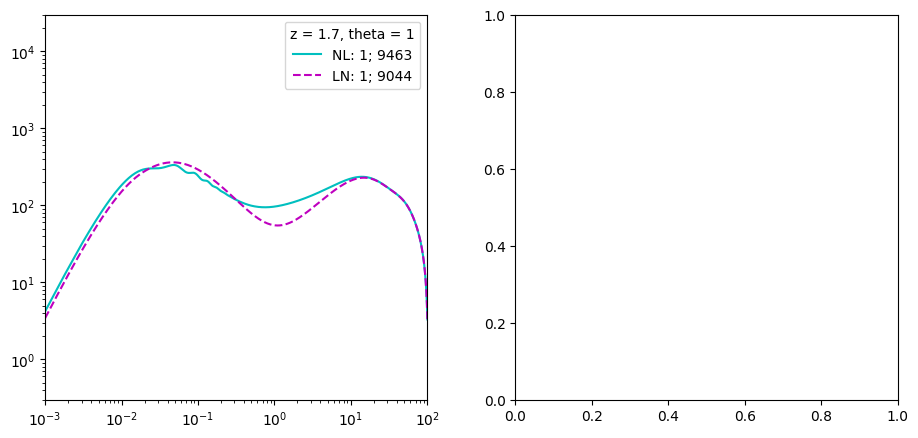

In [6]:
from scipy import integrate
from scipy import special
import mpmath
from hmf import MassFunction
from halomod.bias import Tinker10
from astropy.cosmology import FlatLambdaCDM
cosmo  = FlatLambdaCDM(H0=67.74, Om0=0.3089, Tcmb0=2.725)
OmegaM = cosmo.Om(0)
OmegaL = cosmo.Ode(0)
OmegaK = cosmo.Ok(0)
OmegaB = 0.049
OmegaC = OmegaM-OmegaB
H0 = cosmo.H(0).value
h  = H0/100
c_light  = 299792.458

_PS_NORM_ = HOD.norm_power_spectrum()
M_h_array, HMF_array, nu_array, hmf_k, hmf_PS = HOD.init_lookup_table(z, REWRITE_TBLS=False)
NCEN = HOD.N_cen(M_h_array, M_min, sigma_logM)
NSAT = HOD.N_sat(M_h_array, M_sat, alpha, M_min, sigma_logM)
D_ratio   = (HOD.D_growth_factor(z)/HOD.D_growth_factor(0))**2 if z != 0 else 1
bias = Tinker10(nu=nu_array).bias() if 1 else HOD.halo_bias_TINKER(nu_array)
N_G  = HOD.n_g(M_min, sigma_logM, M_sat, alpha, z, M_h_array, HMF_array)
comoving_distance_z = cosmo.comoving_distance(z).value
crit_dens_rescaled = (4/3*np.pi*cosmo.critical_density(z).value*200*2e40)

USE_MY_PS = 0
if (USE_MY_PS): 
    k_array = np.logspace(-3, 3, 2000)
    dlogk = np.log(k_array[1]/k_array[0])
else:
    k_array = hmf_k
    dlogk = np.log(hmf_k[1]/hmf_k[0])
PS_1 = [HOD.PS_1h(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT) for k in k_array]
PS_2 = [HOD.PS_2h(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT, bias, hmf_k, hmf_PS, D_ratio, _PS_NORM_, USE_MY_PS) for k in k_array]
PS_2_corr =  np.array(PS_2) if USE_MY_PS else hmf_PS * np.array(PS_2)
factor = np.array([HOD.factor_k(k, _theta_/206265, comoving_distance_z) for k in k_array])
F_k_hmf = (np.array(PS_1) + PS_2_corr) * factor
INT_hmf = 1#mpmath.quadosc(F_k_hmf, [0.001, mpmath.inf], period=2*np.pi)
INT_hmf_simps = integrate.simps(F_k_hmf, k_array)


USE_MY_PS = 1
if (USE_MY_PS): 
    k_array = np.logspace(-3, 3, 2000)
    dlogk = np.log(k_array[1]/k_array[0])
else:
    k_array = hmf_k
    dlogk = np.log(hmf_k[1]/hmf_k[0])
PS_1 = [HOD.PS_1h(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT) for k in k_array]
PS_2 = [HOD.PS_2h(k, M_min, sigma_logM, M_sat, alpha, z, crit_dens_rescaled, M_h_array, HMF_array, N_G, NCEN, NSAT, bias, hmf_k, hmf_PS, D_ratio, _PS_NORM_, USE_MY_PS) for k in k_array]
PS_2_corr =  np.array(PS_2) if USE_MY_PS else hmf_PS * np.array(PS_2)
factor = np.array([HOD.factor_k(k, _theta_/206265, comoving_distance_z) for k in k_array])
F_k_anl = (np.array(PS_1) + PS_2_corr) * factor

def Integrand_k(k, theta, comoving_distance_z):
    k / (2*np.pi) * special.j0(k * theta * comoving_distance_z)

INT_anl = 1#mpmath.quadosc(F_k_anl, [0.001, mpmath.inf], period=2*np.pi)
INT_anl_simps = integrate.simps(F_k_anl, k_array)

fig, ax = plt.subplots(1, 2, figsize=(11, 5), sharex=False, sharey=False)
plt.subplots_adjust(wspace=.23, hspace=.2)
ax[0].plot(hmf_k, F_k_hmf, c = 'c', ls = '-', label = 'NL: '+str(int(INT_hmf))+'; '+str(int(INT_hmf_simps)))
ax[0].plot(k_array, F_k_anl, c = 'm', ls = '--', label = 'LN: '+str(int(INT_anl))+'; '+str(int(INT_anl_simps)))
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim((1e-3, 1e2))
ax[0].set_ylim((3e-1, 3e4))
ax[0].legend(title=f'z = {z}, theta = {_theta_}')

H_z = [cosmo.H(z).value for z in z_array]
factor_z =  np.power(np.array(N_z_nrm), 2) / (c_light / np.array(H_z))

intg1 = [HOD.omega_z_component_1(z, _theta_/206265, M_min, sigma_logM, M_sat, alpha, NCEN, NSAT, _PS_NORM_, USE_MY_PS = 0, REWRITE_TBLS = False) for z in z_array]    
intg2 = [HOD.omega_z_component_2(z, _theta_/206265, M_min, sigma_logM, M_sat, alpha, NCEN, NSAT, _PS_NORM_, USE_MY_PS = 0, REWRITE_TBLS = False) for z in z_array]    
intg1_hmf, intg2_hmf = np.array(intg1), np.array(intg2)
OM1_hmf, OM2_hmf = np.trapz(intg1_hmf * factor_z, z_array), np.trapz(intg2_hmf * factor_z, z_array)

intg1 = [HOD.omega_z_component_1(z, _theta_/206265, M_min, sigma_logM, M_sat, alpha, NCEN, NSAT, _PS_NORM_, USE_MY_PS = 1, REWRITE_TBLS = False) for z in z_array]    
intg2 = [HOD.omega_z_component_2(z, _theta_/206265, M_min, sigma_logM, M_sat, alpha, NCEN, NSAT, _PS_NORM_, USE_MY_PS = 1, REWRITE_TBLS = False) for z in z_array]    
intg1_anl, intg2_anl = np.array(intg1), np.array(intg2)
OM1_anl, OM2_anl = np.trapz(intg1_anl * factor_z, z_array), np.trapz(intg2_anl * factor_z, z_array)

ax[1].plot(z_array, intg1_hmf * factor_z, c = 'c', ls = '-'     , label = f'NL 1: {OM1_hmf:.1e}')
ax[1].plot(z_array, intg2_hmf * factor_z, c = 'lime', ls = '-'  , label = f'NL 2: {OM2_hmf:.1e}')
ax[1].plot(z_array, intg1_anl * factor_z, c = 'm', ls = ':'     , label = f'LN 1: {OM1_anl:.1e}')
ax[1].plot(z_array, intg2_anl * factor_z, c = 'orange', ls = ':', label = f'LN 2: {OM2_anl:.1e}')
ax[1].legend()
plt.show()


In [154]:
if(0):
    z = 1.7
    M_sat, M_min, sigma_logM, alpha = 10**14.18, 10**12.46, 0.2, 1.0
    z_array = np.array([1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2])
    N_z_nrm = np.array([0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0])
elif(1):
    z = 1.7
    M_sat, M_min, sigma_logM, alpha = 10**12.48, 10**11.55, 0.2, 1.0
    z_array = np.array([1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2])
    N_z_nrm = np.array([0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0])

elif(0):
    z = 2.9
    M_sat, M_min, sigma_logM, alpha = 10**12.55, 10**11.71, 0.2, 1.0
    data = [
            [2.000000e+00, 2.017570e-02],
            [2.100000e+00, 5.120140e-02],
            [2.200000e+00, 8.963850e-02],
            [2.300000e+00, 1.257240e-01],
            [2.400000e+00, 1.558000e-01],
            [2.500000e+00, 2.025050e-01],
            [2.600000e+00, 2.320880e-01],
            [2.700000e+00, 3.334470e-01],
            [2.800000e+00, 3.349540e-01],
            [2.900000e+00, 4.237170e-01],
            [3.000000e+00, 4.196420e-01],
            [3.100000e+00, 4.230910e-01],
            [3.200000e+00, 4.523410e-01],
            [3.300000e+00, 3.643720e-01],
            [3.400000e+00, 1.837830e-01],
            [3.500000e+00, 4.229380e-02],
            [3.600000e+00, 3.679960e-02],
            [3.700000e+00, 3.273170e-02],
            [3.800000e+00, 5.401130e-02],
            [3.900000e+00, 2.088890e-02],
            [4.000000e+00, 1.080040e-02]
            ]
    z_array = np.array([row[0] for row in data])
    N_z_nrm = np.array([row[1] for row in data])
elif(0):
    z = 4.9
    M_sat, M_min, sigma_logM, alpha = 10**11.86, 10**11.57, 0.2, 1.0
    data = [
    (4.300000e+00, 1.300650e-02),
    (4.400000e+00, 1.332110e-02),
    (4.500000e+00, 1.609830e-01),
    (4.600000e+00, 1.659040e-01),
    (4.700000e+00, 3.460340e-01),
    (4.800000e+00, 2.671030e-01),
    (4.900000e+00, 2.569500e-01),
    (5.000000e+00, 1.880120e-01),
    (5.100000e+00, 1.704260e-01),
    (5.200000e+00, 1.871200e-01),
    (5.300000e+00, 7.831920e-02)
    ]
    z_array, N_z_nrm = np.array(data).T
else:
    z = 5.9
    M_sat, M_min, sigma_logM, alpha = 10**13.73, 10**12.09, 0.2, 1.0
    data = [
    (5.500000e+00, 2.321580e-02),
    (5.600000e+00, 5.284060e-02),
    (5.700000e+00, 1.436010e-01),
    (5.800000e+00, 1.481370e-01),
    (5.900000e+00, 1.036900e-01),
    (6.000000e+00, 1.342000e-01),
    (6.100000e+00, 2.453660e-01),
    (6.200000e+00, 1.546640e-01),
    (6.300000e+00, 1.127430e-02)
    ]
    z_array, N_z_nrm = np.array(data).T

M_h_array, HMF_array, nu_array, hmf_k, hmf_PS = HOD.init_lookup_table(z)
NTOT = HOD.N_tot(M_h_array, M_sat, alpha, M_min, sigma_logM)
N_g_AVG = HOD.get_AVG_N_tot(M_min, sigma_logM, M_sat, alpha, z)
M_h_AVG = HOD.get_AVG_Host_Halo_Mass(M_min, sigma_logM, M_sat, alpha, z)
b_eff = HOD.get_EFF_gal_bias(M_min, sigma_logM, M_sat, alpha, z, USE_MY_BIAS = 0)
f_sat = HOD.get_AVG_f_sat(M_min, sigma_logM, M_sat, alpha, z)
n_avg = HOD.get_N_dens_avg(z_array, M_min, sigma_logM, M_sat, alpha, z, N_z_nrm)

print(f'redshift z   : {z:.2f}')
print(f'n_avg        : {n_avg:.2e}')
print(f'N_g_AVG      : {N_g_AVG:.2e}')
print(f'log(M_h_AVG) : {np.log10(M_h_AVG):.2f}')
print(f'b_eff        : {b_eff:.2f}')
print(f'log(f_sat)   : {np.log10(f_sat):.2f}')
print(f'ln(f_sat)    : {np.log(f_sat):.2f}')

redshift z   : 1.70
n_avg        : 6.03e-03
N_g_AVG      : 6.45e-03
log(M_h_AVG) : 12.46
b_eff        : 1.86
log(f_sat)   : -0.55
ln(f_sat)    : -1.28


In [3]:
_theta_arcsec = np.logspace(-0.5, 3.5, 7)
theta = _theta_arcsec * 1/206265 # 1 arcsec in rad
omega1h, omega2h = HOD.omega_array(theta, M_min, sigma_logM, M_sat, alpha, N_z_nrm, z_array, USE_MY_PS = False, REWRITE_TBLS = False)

  0%|          | 0/7 [00:00<?, ?it/s]

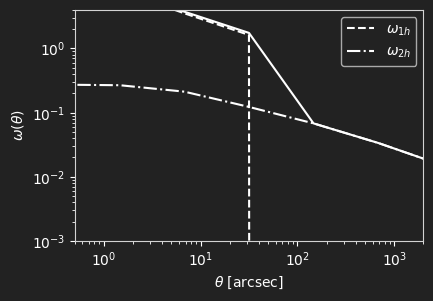

In [4]:
___PLOT_FOR_KEYNOTE___ = 1
COL = 'w' if ___PLOT_FOR_KEYNOTE___ else 'k'
line_c, cmap_c, _col_, col_A, col_B, col_C, col_D, fn_prefix = lens_plot.set_plt_param(___PLOT_FOR_KEYNOTE___)
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3), sharex=False, sharey=False)
ax.plot(_theta_arcsec, omega1h, c = COL,ls = '--', label=r'$\omega_{1h}$')
ax.plot(_theta_arcsec, omega2h, c = COL,ls = '-.', label=r'$\omega_{2h}$')
ax.plot(_theta_arcsec, omega1h+omega2h, c = COL,ls = '-')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((0.5,2e3))
ax.set_ylim((1e-3,4e0)) if z < 3.7 else ax.set_ylim((1e-2,4e1))
ax.set_xlabel(r'$\theta$ [arcsec]')
ax.set_ylabel(r'$\omega$($\theta$)')
plt.legend()
plt.show()